In [511]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG

import pickle

import tensorflow
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn.metrics import (classification_report, multilabel_confusion_matrix, 
                             accuracy_score, recall_score, precision_score, 
                             f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix)

## Model analysis

In this notebook, I will explore the performance of the model, which was trained to classify single dog breeds. I will explore how well the model classifies the 120 breeds that it trained with, and will also conduct a misclassification analysis.

Lastly, for the fun part, we will see how well the model can classify mixed dogs. 

In [2]:
model = load_model('./model_data_softmax/')

2022-06-10 09:35:44.910742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Prepare the images for predictions

In [3]:
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
#num_images= 50
image_arr_size= img_width * img_height * channels

In [4]:
test_data_path = './Testing_images/'

In [5]:
test_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle=False
)

Found 3633 images belonging to 120 classes.


In [6]:
class_indeces = test_generator.class_indices
label_names = list(test_generator.class_indices.keys())
y_true = test_generator.classes

In [514]:
with open("labels", "wb") as fp:   #Pickling
    pickle.dump(label_names, fp)

In [7]:
preds = model.predict(test_generator)
single_breed_preds = np.argmax(preds, axis=1)

#### Accuracy score - across all breeds:

In [531]:
accuracy_score(y_true, single_breed_preds)

0.8634737131846958

#### Global ('micro') precision score

In [536]:
precision_score(y_true, single_breed_preds, average='micro')

0.8634737131846958

### High-level performance report

Let's see the precision, recall, and f1-score per breed

In [8]:
classification_report = classification_report(y_true, single_breed_preds, target_names=label_names)
print(classification_report)

                                precision    recall  f1-score   support

                 Affenpinscher       0.76      1.00      0.87        13
                        Afghan       0.98      0.98      0.98        50
              African Wild Dog       0.98      1.00      0.99        50
                      Airedale       0.92      0.92      0.92        50
American Staffordshire Terrier       0.81      0.92      0.86        50
                   Appenzeller       1.00      0.33      0.50        12
            Australian Terrier       0.50      1.00      0.67        12
                       Basenji       0.96      1.00      0.98        50
                        Basset       0.98      0.96      0.97        50
                        Beagle       0.94      0.94      0.94        50
            Bedlington Terrier       1.00      1.00      1.00        13
          Bernese Mountain Dog       1.00      0.96      0.98        50
       Black-and-Tan Coonhound       0.71      0.91      0.80  

In [521]:
high_recall = 0
high_precision = 0

for key in label_names:
    if report_dict[key]['recall'] > .90:
        high_recall +=1
    if report_dict[key]['precision'] > .90:
        high_precision +=1
print(high_recall/120, high_precision/120)

0.6083333333333333 0.45


We can see that slightly over 60% of the breeds that recall scores of .90 or higher.
However, only 45% of breeds enjoyed precisions score of 0.90 or higher

## Analysis of most misclassified breeds
We will review the breeds with low recall scores (below < 0.50) and breeds with low precision scores (below <0.50) to see if we can gain any insight as to the model's mistakes. 
 
- Note that breeds with low recall scores means that the breed had a lot of FALSE NEGATIVES, meaning when the model would see this breed, it classifyied it as another breed over 50% of the time. 

- Breeds with low precision scores means breeds that had a lot of FALSE POSSITIVES, so over 50% of the time that the model predicted this breed, it was incorrect.

#### Let's iterate through the report to pull the breeds with the low recall and with low precision scores

In [12]:
report_dict = classification_report(y_true, single_breed_preds, target_names=label_names, output_dict=True)

In [13]:
def low_recall_precision_labels(report_dict, labels_names):
    low_recall = []
    low_precision = []
    for key in label_names:
        if report_dict[key]['recall'] < .50:
            low_recall.append(key)
        if report_dict[key]['precision'] < .50:
            low_precision.append(key)
            
    return low_recall, low_precision

In [14]:
low_recall, low_precision = low_recall_precision_labels(report_dict, label_names)
print('Low_recall:',low_recall)
print('Low_precision', low_precision)

Low_recall: ['Appenzeller', 'Brittany Spaniel', 'Cocker Spaniel', 'Eskimo Dog', 'Lakeland Terrier', 'Lhasa', 'Pinscher', 'Silky Terrier', 'Toy Poodle']
Low_precision ['Eskimo Dog', 'Giant Schnauzer', 'Kelpie', 'Miniature Poodle', 'Scottish Deerhound', 'Silky Terrier', 'Tibetan Terrier']


## Review of breeds with low recall scores

In [177]:
#### Create a dict mapping label index to breed
ind_to_label = {}
for k, i in class_indeces.items():
    ind_to_label[i] = k.title()

In [16]:
true_pred = pd.DataFrame({'y_true': y_true, 'y_pred': single_breed_preds})

In [34]:
### Structure of function below

# class_indeces['Brittany Spaniel']

# true_pred[true_pred['y_true']==class_indeces['Brittany Spaniel']]

# brittany_spaniel = true_pred[true_pred['y_true']==class_indeces['Brittany Spaniel']]
# mislabel_ind = brittany_spaniel[brittany_spaniel['y_pred']!=class_indeces['Brittany Spaniel']]
# most_mislabed = mislabel_ind['y_pred'].mode()[0]
# most_mislabed_breed = ind_to_label[most_mislabed]
# most_mislabed_breed

In [32]:
def recall_mislabeling(df, breed_list, index_dict):
    '''
    Function that returns dictionary where the keys are breeds with low recall scores
    and values are the breeds that they are mislabeled as the most.  
    
    '''
    mislabel_dict = {}
    for breed in breed_list:
        df_subset = df[df['y_true']==class_indeces[breed]]
        mislabel_ind = df_subset[df_subset['y_pred']!=class_indeces[breed]]
        most_mislabed = mislabel_ind['y_pred'].mode()[0]
        most_mislabed_breed = ind_to_label[most_mislabed]
        mislabel_dict[breed] = most_mislabed_breed
    
    return mislabel_dict

In [142]:
low_recall_dict = recall_mislabeling(true_pred, low_recall, ind_to_label)
low_recall_dict

{'Appenzeller': 'Entlebucher',
 'Brittany Spaniel': 'Welsh Springer Spaniel',
 'Cocker Spaniel': 'Irish Water Spaniel',
 'Eskimo Dog': 'Samoyed',
 'Lakeland Terrier': 'Airedale',
 'Lhasa': 'Shih-Tzu',
 'Pinscher': 'Doberman',
 'Silky Terrier': 'Australian Terrier',
 'Toy Poodle': 'Miniature Poodle'}

#### To analyze the breeds that have been most mislabeled, let's looks at images of those breeds and the breeds that they were most mistaken for:

I suspect that the model was confusing breeds that look very much like each other, let's see if that's true.

In [367]:
mislabeled_imgs = []

for key, value in low_recall_dict.items():
    img1 = load_img('./Testing_images/'+ key + '/001.jpg')
    img2 = load_img('./Testing_images/'+ value + '/001.jpg')
    mislabeled_imgs.append([img1, img2])

In [301]:
def print_pair(image_list, title1, title2):
    f, axarr = plt.subplots(1,2, figsize=(12,12))
    axarr[0].imshow(image_list[0])
    axarr[0].set_title(title1)
    axarr[0].axis('off')

    axarr[1].imshow(image_list[1])
    axarr[1].set_title(title2)
    axarr[1].axis('off');

##### Let's explore Appenzeller which was widely misclassified as an Entlebucher

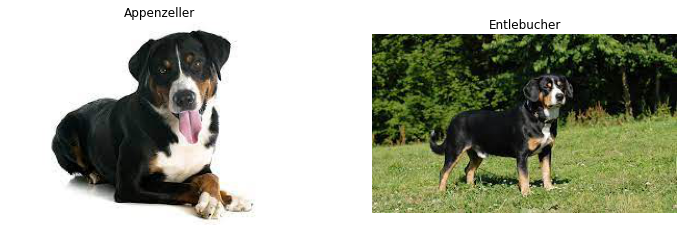

In [302]:
print_pair(mislabeled_imgs[0], 'Appenzeller', 'Entlebucher')

Both dogs have short hair and similar color pattern. In fact, both are part of the **SAME BREED GROUP** the Switzerland mountain dog, which includes the Greater Swiss Mountain Dog, the Bernese Mountain Dog,  the Entlebucher, and the Appenzeller. With the Bernese Mountain dog having the longest hair, it was distinguished enough that it enjoyed high precision and recall scores. We did not test the Swiss Mountain Dog. But the model had a hard time distinguishing the two dogs above, since there are overlaps in their size and weight, with the Entlebucher being only slightly smaller on average. Since I used data from the standford model study, I maintained the same classes as they did, but I may reconsider in the future how to treat dogs that belong to the same breed group and are very similar in appearance. 

##### Review of the Brittany Spaniel which was confused for the Welsh Springer Spaniel

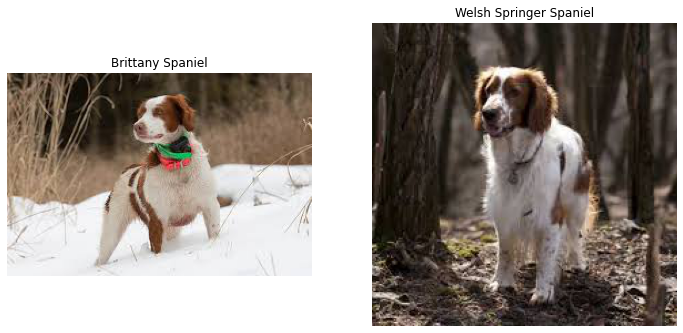

In [310]:
print_pair(mislabeled_imgs[1], 'Brittany Spaniel', 'Welsh Springer Spaniel')

These two breeds are so incredibly similar, with a mostly white coat but a very similar reddish part around the face and body. When I was reviewing images for both classes, I could hardly tell the difference, other than the Brittany Spaniel has shorter ears (on average) than the Welsh Spaniel. Another troubling part was that the Stanford data had mixed these two breeds, and so the folder for each class has incorrectly added pictures of one another. 

##### Let's see the Cocker Spaniel which was most mislabeled as an Irish Water Spaniel

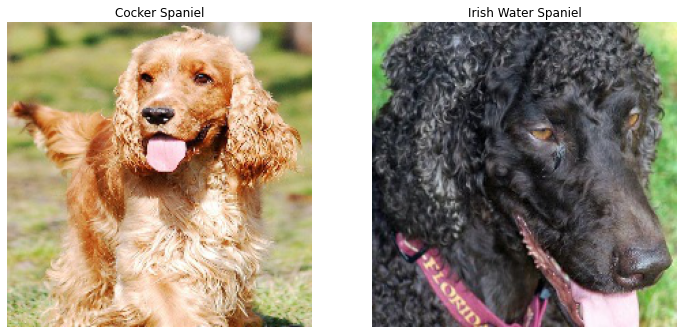

In [313]:
print_pair(mislabeled_imgs[2], 'Cocker Spaniel', 'Irish Water Spaniel')

I attribute the mixed up between these two breeds to the fact that the Stanford dataset combined images of the English and the American Cocker Spaniels into one group and they actually look quite different. So I believe the model simply did not correctly learn how to identify this class. The Irish Water Spaniel did have pretty good recall score and a precision score of .76, so I believe the model had learn to recognize this breed. 

##### Let's explore the Eskimo Dog which was most confused for a Samoyed'

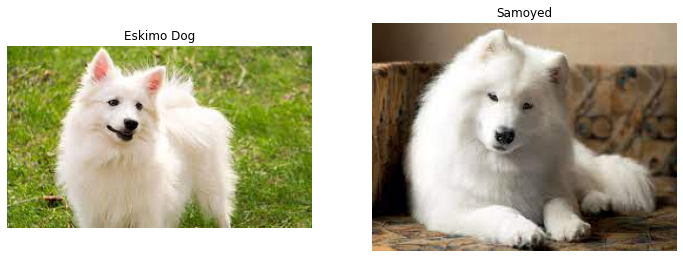

In [314]:
print_pair(mislabeled_imgs[3], 'Eskimo Dog', 'Samoyed')

These two white fluffy breeds share a strikling similarity, so initially, I believed that this mistake happened because of their similar looks. However, I was very skeptical that the Eskimo dog had 0.0 in precision and 0.0 in recal scores, and upon further investigation, I see that the Stanford data completely misclassified the Eskimo Dog, and added pictures from another breed. Because at this point of my project, it is too late to retrain my model and do a completely new analysis, I will simply say that we cannot count the Eskimo dog as a breed that the model learned and then misclassified since the data was corrupted. 

**Review of the Lakeland Terrier which was most misclassified as an Airedale**

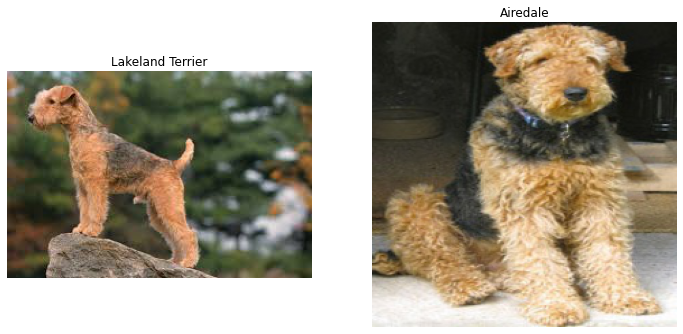

In [318]:
print_pair(mislabeled_imgs[4], 'Lakeland Terrier', 'Airedale')

Both the Lakeland Terrier and the Airedale are part of the terrier family. They look quite similar but differ in overall size. The Lakeland's typical height reaches between 13 to 15 inches, whereas the Airedale can get as big as 21 to 23 inches tall. 

**Review of the Lhasa which was most mislabeled for a Shih-Tzu**

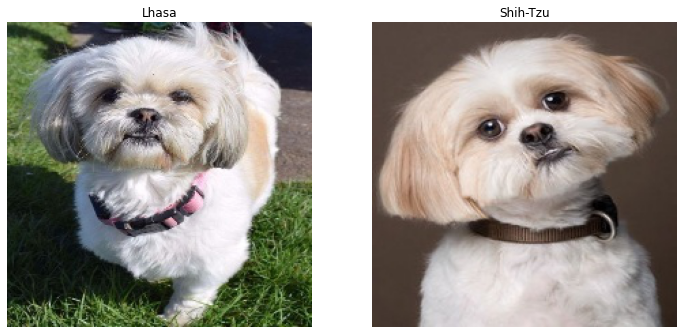

In [321]:
print_pair(mislabeled_imgs[5], 'Lhasa', 'Shih-Tzu')

Lhasas and Shih-Tzus are so strikingly similar because Shih Tzus were in fact developed from the Lhasa Apso which is a breed originally from Tibet. Although the Shih Tzu breed had a higher recall score than the Lhasa, the model did tend to mislabel Shih Tzus as Lhsas quite a bit. 

**Review of the Pinscher which was most mislabeled as Doberman**

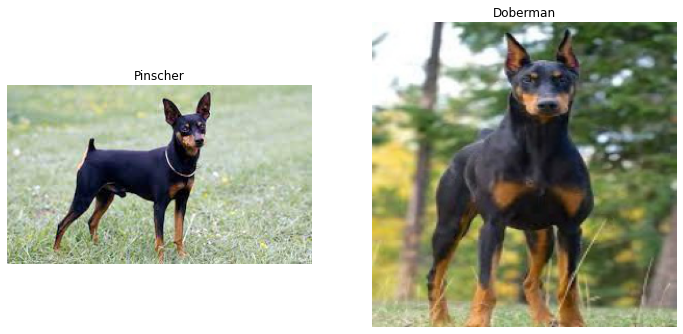

In [326]:
print_pair(mislabeled_imgs[6], 'Pinscher', 'Doberman')

Both breeds originate from Germany and while, yes they share some visual similarities, they differ are quite different in size. The Pinsher tends to be 17-20 inches tall while the Doberman grows to be about 24-28 inches tall. I suspect the model could not quite tell the size difference. 

**Review of the Silky Terrier, most mistaken for an Australian Terrier**

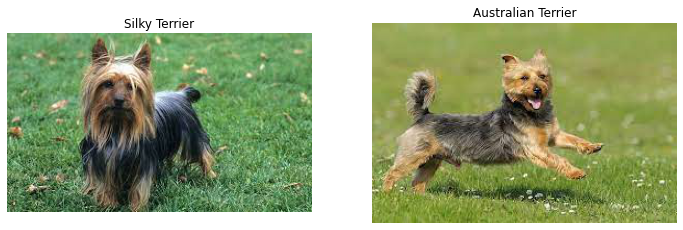

In [327]:
print_pair(mislabeled_imgs[7], 'Silky Terrier', 'Australian Terrier')

Both Breeds can look quite similar, with the Australian Terrier having a slightly more shaggy hair. It is not surprising however, that the model would mistake these two. 

**Review of the Toy Poodle which was mislabeled as Miniature Poodle**

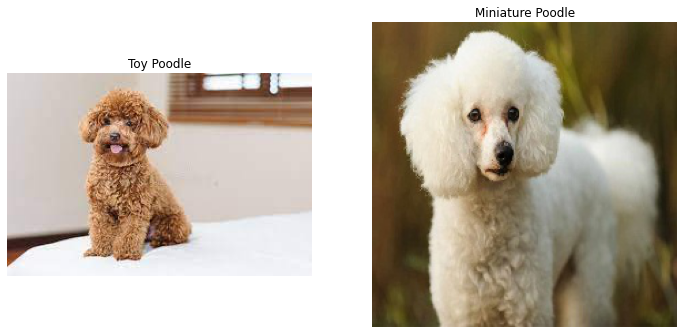

In [356]:
print_pair(mislabeled_imgs[8], 'Toy Poodle', 'Miniature Poodle')

It is no surprise that the Toy and the Miniature Poodles would be confused for each other. They are basically the same breed, with the difference only being in size. It may be worth considering making a 'Poodle' category that simply identifies Poodles without distinguishing between size of Poodle. I also suspect the data was not clean, and that each folder contained both toy and miniature poodles since they are very hard to distinguish. 

### Summary on low recall score analysis:

We see that low recall scores can be attributed to breeds that look very similar and some share a similar genetic background. Given that this model trained on visual cues, I think that it makes sense that it would make these mistakes. For breeds that look similar but differ in height, it may be worth training the model with pictures that show the entire body of the dog (many pictures only show the dog partially, i.e. face only pictures.) and testing the model on pictures that show the entire body so that the model can better see body proportions. In a few cases of low recall scores, we also see that the data was corrupted, and in the case of the Eskimo Dog, the pictures were entirely wrong! 

## Review of breeds with low precision score

In [322]:
def precision_mislabeling(df, breed_list, index_dict):
    '''
    Function that returns dictionary where the keys are breeds with low precision scores
    meaning the model made many false positives and return the correct breed class.  
    
    '''
    mispred_dict = {}
    for breed in breed_list:
        df_subset = df[df['y_pred']==class_indeces[breed]]
        mislabel_ind = df_subset[df_subset['y_true']!=class_indeces[breed]]
        most_mislabed = mislabel_ind['y_true'].mode()[0]
        most_mislabed_breed = ind_to_label[most_mislabed]
        mispred_dict[breed] = most_mislabed_breed
    
    return mispred_dict

In [323]:
low_precision_dict = precision_mislabeling(true_pred, low_precision, ind_to_label)
low_precision_dict

{'Eskimo Dog': 'Siberian Husky',
 'Giant Schnauzer': 'Bouvier Des Flandres',
 'Kelpie': 'Malinois',
 'Miniature Poodle': 'Standard Poodle',
 'Scottish Deerhound': 'Irish Wolfhound',
 'Silky Terrier': 'Yorkshire Terrier',
 'Tibetan Terrier': 'Lhasa'}

In [363]:
mispredicted_imgs = []

for key, value in low_precision_dict.items():
    img1 = load_img('./Testing_images/'+ key + '/001.jpg')
    img2 = load_img('./Testing_images/'+ value + '/001.jpg')
    mispredicted_imgs.append([img1, img2])

**Review of Eskimo Dog which the model mispredicted most as Siberian Husky**

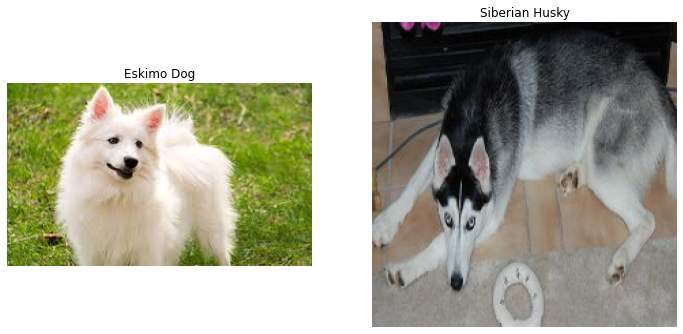

In [366]:
print_pair(mispredicted_imgs[0], 'Eskimo Dog', 'Siberian Husky')

As I mentioned above, the Stanford made a huge mistake and added the wrong pictures for the Eskimo Dog, so the model did not learn what an Eskimo Dog looks like

**Review of the Giant Schnauzer which was most mispredicted as a Bouvier Des Flandres**

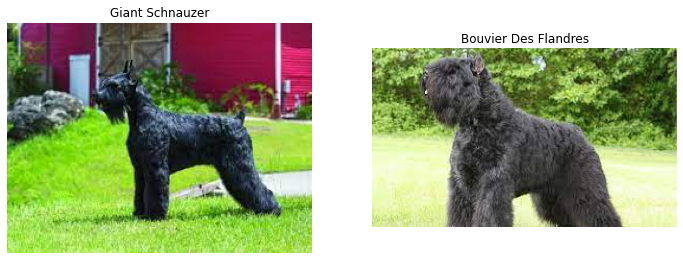

In [369]:
print_pair(mispredicted_imgs[1], 'Giant Schnauzer', 'Bouvier Des Flandres')

These two breeds are so similar in size, shape, and coat that I am not surprised that the model had a high level of False Positives which confused Bouvier Des Flandres for Giant Schnauzer

**Review of the Kelpie which the model confused with the Malinois**

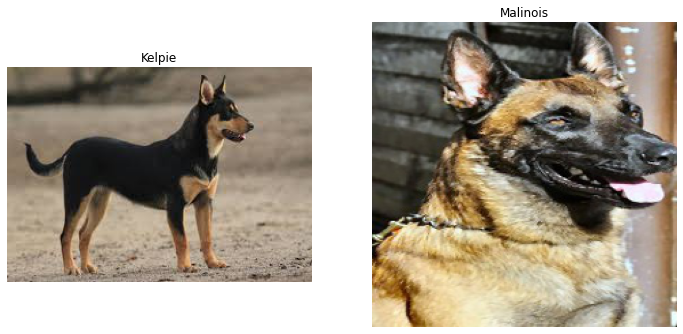

In [370]:
print_pair(mispredicted_imgs[2], 'Kelpie', 'Malinois')

In this case, the model did predict Kelpies well, but it did have many false positives for Kelpies. Out of the false positive, the majority of those, the actual dog breed was Malinois, which is a little confusing since these dog do not share many similarities. However, I noticed that the folder for Kelpie photos was littered with many incorrect pictures, so this is a case where dirty data may have incorrectly trained the model. 

**Review of the Miniature Poodle which was mispredicted when it fact the dog was a Standard Poodle**

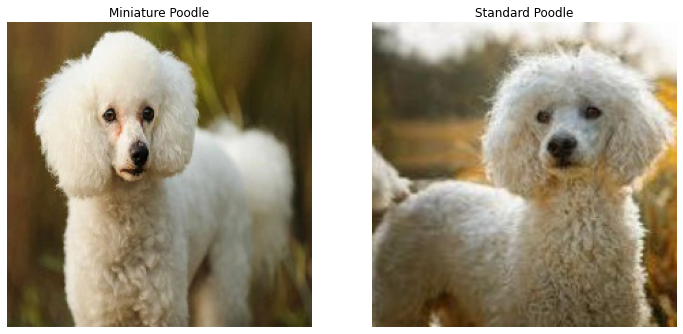

In [372]:
print_pair(mispredicted_imgs[3], 'Miniature Poodle', 'Standard Poodle')

Right, we know what the model tended to make this mistake. 

**Review of the Scottish Deerhound and Irish Wolfhound**

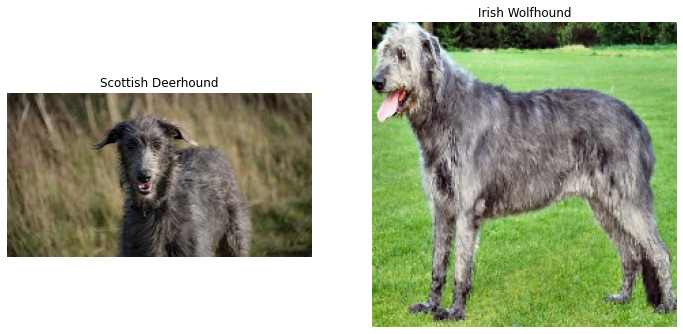

In [374]:
print_pair(mispredicted_imgs[4], 'Scottish Deerhound', 'Irish Wolfhound')

The two breeds are in fact, very difficult to tell apart. The main difference is that the Irish Wolfhound is taller with longer legs. 

**Review of the Silky Terrier which had many false positive when the breed was Yorkshire Terrier**

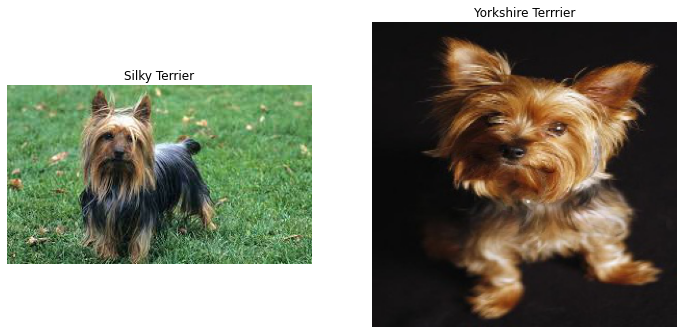

In [375]:
print_pair(mispredicted_imgs[5], 'Silky Terrier', 'Yorkshire Terrrier')

Not only are these two breeds very similar, but I suspect that the data between both breeds has been mixed up. 

**Review of the Tibetan Terrier which had many false positive when the breed was Lhasa**

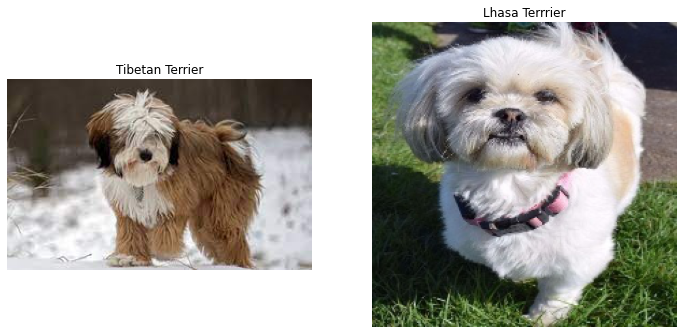

In [378]:
print_pair(mispredicted_imgs[6], 'Tibetan Terrier', 'Lhasa Terrrier')

The Tibetan Terrier is much larger than the Lhasa Terrier, but the model is not always good at distinguishing sizes. Both breeds originate from Tibet, and some believe that they are related. 

### Sumary on low precision score analysis:

The the breeds with low precision scores, had many false positives with breeds that looked very much alike. In some cases, like the Eskimo Dog and the Kelpie, the data was very dirty and needs to be corrected. As mentioned above, regarding breeds with low recall score, many mistakes occur when the model cannot tell the difference in breed sizes, and in other cases, the model confuse dogs that are just so visually similar that it would be difficult to correct for that mistake. 

### Confusion Matrix for single-breed predictions
Although I have summarized breeds where the model was many over 50% mistakes in the predictions (recall and precision scores), below, you can further explore the numbers via a confusion matrix. 

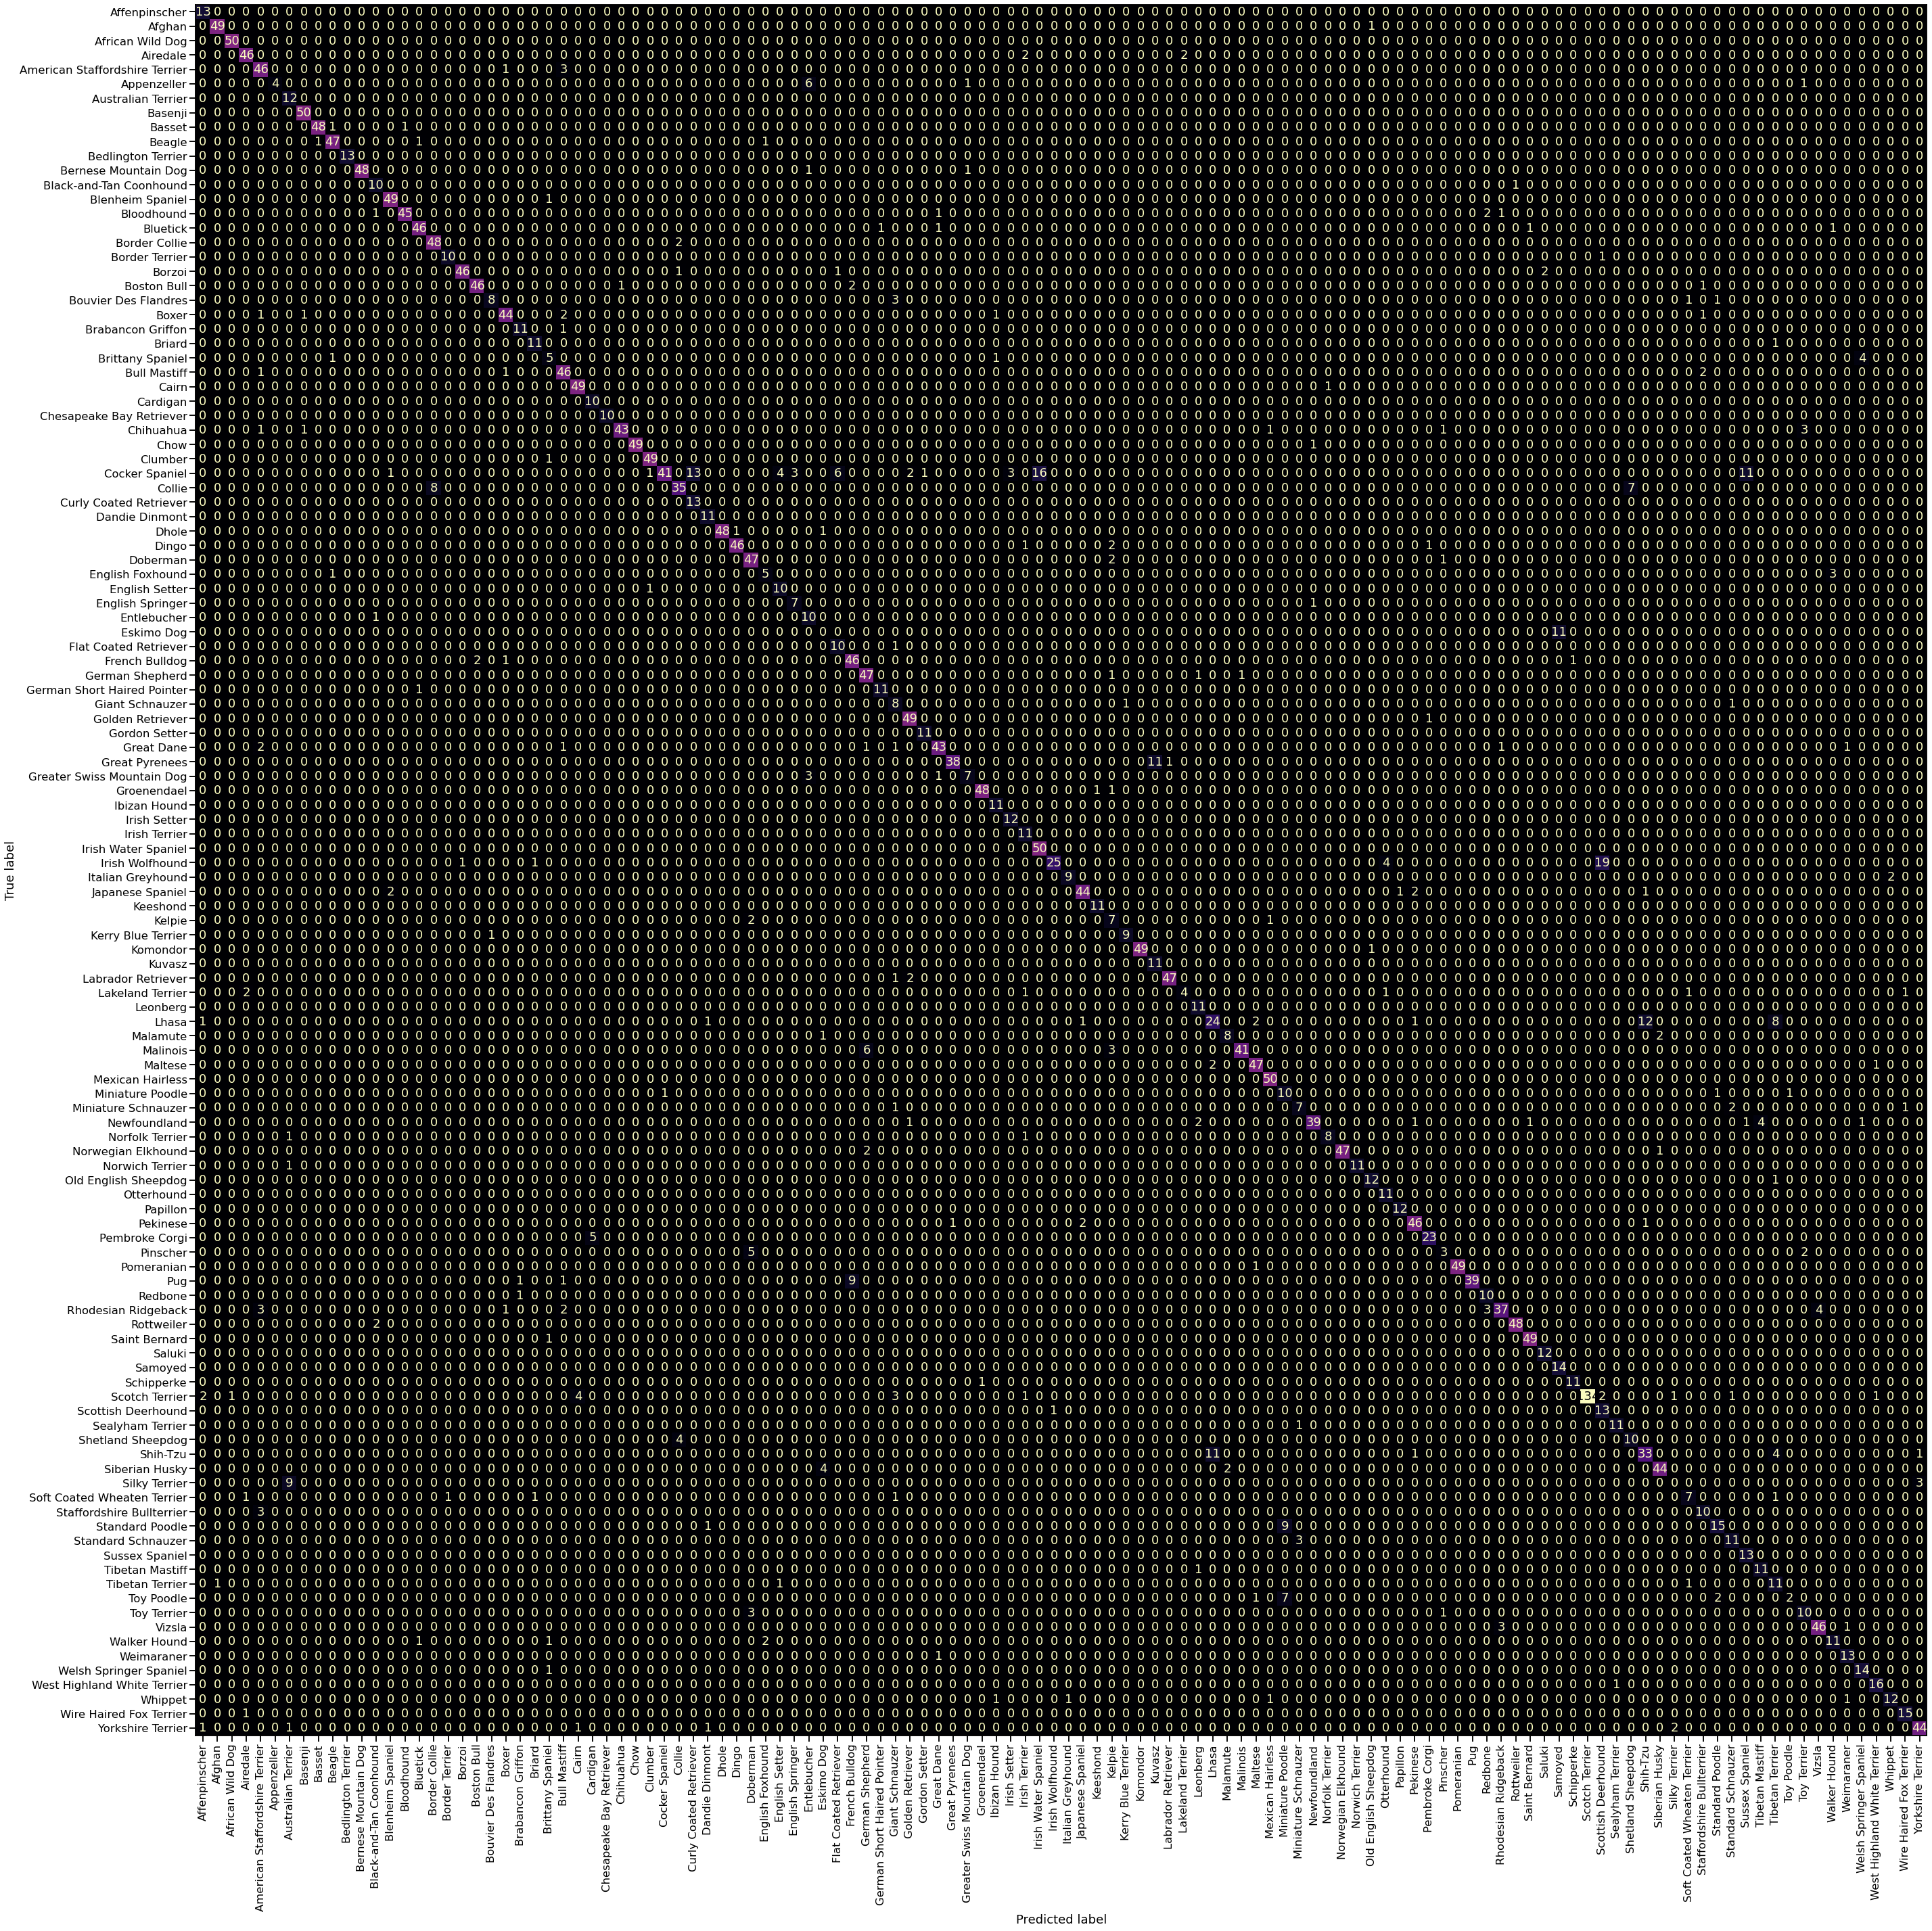

In [61]:
cm = confusion_matrix(y_true, single_breed_preds)
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='magma', colorbar=False)
plt.tight_layout()
plt.show()

## Time for fun: Let's look at how well the model predicts mixed breeds 

In [78]:
mixed_breeds_path = './mix_images/'

In [79]:
mixed_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

mixed_generator = mixed_datagen.flow_from_directory(
    mixed_breeds_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle=False
)

Found 124 images belonging to 12 classes.


#### Generate predictions with mixed dogs

I am testing the model above on how well it can predict mixed dogs. Because this model was not trained to do multi-label classification, I am doing this part of this project for fun and curiosity. 

Instead of passing the results from softmax through np.argmax to get the top prediction, I am going to take the top ten predicted dog breeds and see if within those top ten, whether the model is able to properly guess the different breeds that the dog is mixed with. 

Since this part if mostly for fun, I decided to throw my model a few softballs and I am testing its ability to predict dogs that are mixed with only two breeds. The mixes include:
- Bernese Mountain Dog and Standard Poodle
- Border Collie and Shetland Sheepdog
- Boxer and Labrador Retriever 
- Chihuahua and Beagle
- Golden Retriever and German Shepherd
- Papillon and Maltese
- Pembroke Corgi and Labrador Retriever
- Pembroke Corgi and Miniature Poodle
- Pomeranian and Siberian Husky
- Yorkshire Terrier and Miniature Poodle

I suspect the model will have a hard time correctly predicting those that mixtures with poodles and corgies since we have three poodle classes and we have two corgi classes all of which look similar. 

In [82]:
mixed_preds = model.predict(mixed_generator)

In [482]:
mixed_preds_sort = np.argsort(mixed_preds, axis=1)

file_path = mixed_generator.filenames

#### Make a dataframe with the results

This dataframe will contrain a list of the true breeds, a list of the predicted breeds, the top prediction, and whether there is at least a single match, all matches, and if the model's top prediction is of at least one of the right breeds

In [483]:
#predicted preds will have filepath as key and value as the top 10 predicted breeds
predicted_breeds = {}
i = 0
for arr in mixed_preds_sort:
    temp_list = [ind_to_label[index] for index in arr[-10:]]
    predicted_breeds[file_path[i]] = temp_list[::-1]
    i +=1

In [484]:
pred_breeds = pd.DataFrame(data=predicted_breeds.items(), columns=['file_path', 'predicted_breeds'])

In [485]:
def make_title(breeds):
    return [breed.title() for breed in breeds]

In [486]:
def get_breeds(row):
    breed_list = []
    breeds = row['file_path']
    breeds = breeds[:breeds.find('/')]
    breed_list.append(breeds.split('_'))
    outcome = make_title(breed_list[0])
    return outcome

In [487]:
pred_breeds['true_breeds'] = pred_breeds.apply(get_breeds, axis=1)

In [488]:
def get_top_guess(row):
    breeds = row['predicted_breeds']
    top_guess = breeds[0]
    return top_guess

In [489]:
pred_breeds['top_guess'] = pred_breeds.apply(get_top_guess, axis=1)

In [490]:
matches = []
for ix in pred_breeds.index:
    predicted_breeds = pred_breeds.loc[ix, 'predicted_breeds']
    actual_breeds = pred_breeds.loc[ix, 'true_breeds']
    matches.append(any([breed in actual_breeds for breed in predicted_breeds]))

pred_breeds['any_matches'] = matches

In [491]:
all_matches = []
for ix in pred_breeds.index:
    predicted_breeds = pred_breeds.loc[ix, 'predicted_breeds']
    actual_breeds = pred_breeds.loc[ix, 'true_breeds']
    all_matches.append(all([breed in predicted_breeds for breed in actual_breeds]))

pred_breeds['all_matches'] = all_matches

In [492]:
def eval_top_guess(row):
    breeds = row['true_breeds']
    top_guess = row['top_guess']
    
    if top_guess in breeds:
        return True
    else:
        return False

In [493]:
pred_breeds['eval_top_guess'] = pred_breeds.apply(eval_top_guess, axis=1)

In [494]:
#pred_breeds.drop(columns='file_path', inplace=True)

In [495]:
pred_breeds.head()

file_path  \
0  Bernese Mountain Dog_Standard Poodle/download-...   
1  Bernese Mountain Dog_Standard Poodle/download-...   
2  Bernese Mountain Dog_Standard Poodle/download-...   
3  Bernese Mountain Dog_Standard Poodle/download-...   
4  Bernese Mountain Dog_Standard Poodle/download-...   

                                    predicted_breeds  \
0  [Tibetan Terrier, Bernese Mountain Dog, Old En...   
1  [Saint Bernard, Tibetan Mastiff, Leonberg, Tib...   
2  [Old English Sheepdog, Tibetan Terrier, Bernes...   
3  [Bernese Mountain Dog, Appenzeller, Greater Sw...   
4  [Bernese Mountain Dog, Appenzeller, Greater Sw...   

                               true_breeds             top_guess  any_matches  \
0  [Bernese Mountain Dog, Standard Poodle]       Tibetan Terrier         True   
1  [Bernese Mountain Dog, Standard Poodle]         Saint Bernard        False   
2  [Bernese Mountain Dog, Standard Poodle]  Old English Sheepdog         True   
3  [Bernese Mountain Dog, Standard Poodle]  Bernese Mountain Dog         True   
4  [Bernese Mountain Dog, Standard Poodle]  Bernese Mountain Dog         True   

   all_matches  eval_top_guess  
0        False           False  
1        False           False  
2         True           False  
3        False            True  
4        False            True

#### Evaluation of the model's ability to predict mixed-breed dogs

As I've mentioned above, I have not trained the model for multilabel classification, so this is purely a fun exercise. In order to evaluate this model, I am just looking at some global performance of the model and will not be using any rigorous methods.

#### For mixed dogs, out of the top ten predictions, at what rate was the model able to find at least one match?

In [508]:
total_preds = len(pred_breeds)
any_matches = pred_breeds['any_matches'].sum()

rate_of_any_match = any_matches/total_preds
rate_of_any_match

0.8790322580645161

Out of the top ten predictions, the model was able to find at least one match at a rate of about 88%. This is not bad, I am quite impressed by this!

#### Out of the top ten predictions, at what rate was the model able to correctly find both breeds for each dog?

In [509]:
total_preds = len(pred_breeds)
all_matches = pred_breeds['all_matches'].sum()

rate_of_all_match = all_matches/total_preds
rate_of_all_match

0.3064516129032258

The model was able to predict both breeds (in its top ten predictions) only 31% of the time. So in its top ten predictions, the model will predict all (two total) breeds about one-third of the time. Not great, but also not bad. This is much better than just guessing. 

### Summary on mixed-breed classification

Out of the top 10 predictions, the model does a pretty good job of capturing at least one of the breeds. In guess both breeds, the model performs falls significatly. I nonetheless think that it may be worth making your mixed-breed estimations and then comparing it to the modedl's top ten guesses to see if it is likely that at least one breed has been captured. 

Ultimately, however, I suggest that a specific multilabel model to be build for mixed-breed dogs. 